# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.559117,False,-4.947211
1,-1.097597,False,-3.652108
2,0.281786,True,4.491823
3,-1.779724,False,-4.532002
4,0.553455,True,7.630840
...,...,...,...
995,-0.792842,False,-2.925580
996,-1.512340,False,-5.416895
997,-2.787478,False,-6.956076
998,-1.178318,False,-4.332932


<AxesSubplot:xlabel='v0'>

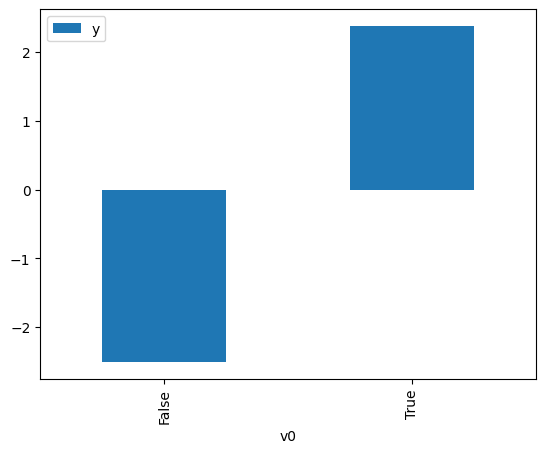

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

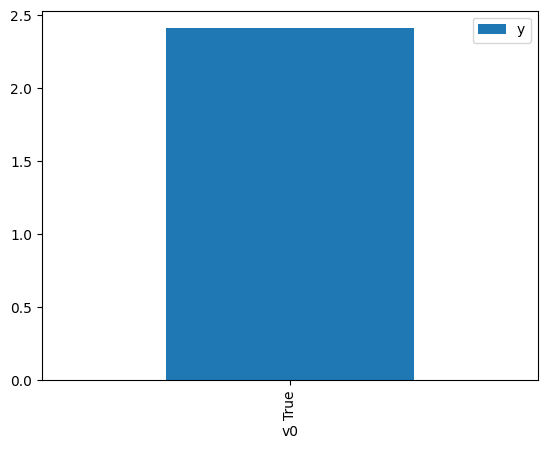

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.108705,False,-4.504503,0.722942,1.383237
1,-0.767562,False,-3.118559,0.650111,1.538198
2,1.020640,False,3.904776,0.238585,4.191372
3,-1.288116,False,-5.489351,0.757255,1.320559
4,-3.379873,False,-9.860514,0.961574,1.039962
...,...,...,...,...,...
995,0.467256,False,-1.350665,0.352148,2.839716
996,-0.767562,False,-3.118559,0.650111,1.538198
997,0.521243,False,3.161459,0.339987,2.941286
998,1.310790,False,2.355850,0.190115,5.259986


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.487016,True,4.027125,0.415743,2.405330
1,-1.798656,True,-1.793601,0.161667,6.185571
2,-0.362503,True,4.791171,0.446127,2.241514
3,-0.263394,True,4.304625,0.470614,2.124882
4,-1.585595,True,-0.113548,0.192508,5.194602
...,...,...,...,...,...
995,-0.835189,True,2.038454,0.334736,2.987432
996,-0.061586,True,3.100156,0.520788,1.920166
997,-0.917817,True,1.727651,0.316675,3.157807
998,-0.191045,True,4.742772,0.488587,2.046720


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9900.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:55:56   Log-Likelihood:                         -1425.8
No. Observations:                1000   AIC:                                      2856.
Df Residuals:                     998   BIC:                                      2865.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9493      0.025    119.839      0.000       2.901       2.998
x2             4.9637      0.054     91.525      0.000       4.857       5.070
==============================================================================
Omnibus:                        2.847   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.877
Skew:                          -0.068   Prob(JB):                        0.237
Kurtosis:                       3.225   Cond. No.                         2.24
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""